# THE PBDW method


In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-fem

#### Let us present one method that combines model order reduction and a data assimilation problem: the Parametrized-Background Data-Weak method (PBDW). 
The PBDW method exploits data observations and the knowledge of a parameterized best-knowledge (bk) model that describes the physical system, to improve performance. We denote by $u^{bk}(\mu) \in \mathcal{U}$, the solution to the parameterized model for the parameter value $\mu \in \mathcal{P}^{bk}$, 
                                                                                                                                             $$ G^{bk,\mu}(u^{bk}(\mu)) = 0.$$
Here, $G^{bk,\mu}(\cdot)$ denotes the parameterized bk model associated with the system, and $\mathcal{P}^{bk} \subset \mathbb{R}^P$ is a compact set that reflects the lack of knowledge in the value of the model parameters. We further define the bk solution manifold
$$ \mathcal{M}^{bk} = \{u^{bk}(\mu) : \mu \in \mathcal{P}^{bk}\}.$$

The PBDW formulation integrates the parameterized mathematical model $G^{pb}$ and $M$ experimental observations associated with a parameter configuration $\mu^{true}$ to estimate the true field $u^{true}(\mu^{true})$ as well as any desired output $l_{out}(u^{true}(\mu^{true}\
)) \in \mathbb{R}$ for given output functional $l_{out}$.                                                                                                                  
We intend that $\lVert u^{true}(\mu^{true})-u^{bk}(\mu^{true}) \rVert$ is small (i.e. that our model represents our data observations well).

The PBDW is decomposed in two parts: one offline and one online.

In the following notebook, we will employ:
- as our model problem a 2D advection-diffusion problem,
- some measures that could also be possibly be noisy (here we will consider the case with no noise),
- a sequence of background spaces that reflect our (prior) best knowledge model bk, 
- gaussians for our observations with a proper choice of localization.
  
We will create measures artificially from our model problem by modifying the right hand side of our equation and the boundary conditions.

To generate the sequence of background spaces, we will employ a POD basis (but any other offline algorithm could be used such as a weak-Greedy procedure). We will denote these spaces by 
$$\mathcal{Z}_1 \subset \dots \subset \mathcal{Z}_{N} \subset \mathcal{U}. $$                                                                                                                                                                                                              
To sum up, we consider two main ingredients:                                                                                                                                                                                                               
- a model with a bias leading to the $(\mathcal{Z}_n)_n$ sequence,                                                                                                                                                                        
- and true measures, that might be noisy.                                                                                                                                                                                               
                                                                                                                                              

In [1]:
# import packages
import skfem  # for Finite Element Method
import numpy as np
import matplotlib.pyplot as plt

## The 2D advection-diffusion model problem:

We are going to use in this example a 2D  advection-diffusion problem with the Finite Element Method (FEM), which consists in 
solving on a unit square (denoted $\Omega$) the following equations:
\begin{align}
&- \Delta u + b(\mu) \cdot \nabla u =x_1 x_2 + g_1, \textrm{ in } \Omega,\\
& u=4 x_2(1-x_2)(1+g_2), \textrm{ on } \Omega_{left}:=\partial \Omega \cap \{x=0\},\\
& \partial_n u (\mu)=0, \textrm{ on } \partial \Omega \backslash \Omega_{left},
\end{align}
where $u \in H^1(\Omega)$ represents the unknown, $\mu \in \mathbb{R}^2$ is our variable parameter, and $g_1$ and $g_2$ are two functions that allow us to construct a model with a bias with respect to the data observations. The lack of knowledge of the value of $\mu$ constitutes the anticipated parametric ignorance in the model, while uncertainty in $g_1$ and $g_2$ constitutes the unanticipated non-parametric ignorance.

We employ $P1$ finite elements to get a proper solution and obtain the system $\mathbf{A} \mathbf{x} =\mathbf{f}$ to solve where the assembled matrix $\mathbf{A}$ corresponds to the bilinear part $\int_{\Omega} (\nabla u, \nabla v) - (b(\mu),\nabla v) u + \int_{\Omega_{left}} (b(\mu), \nabla_n u) v $.

The dirichlet boundary conditions are imposed with a penalization method, called by the line: 
solve(*condense(K,f, x=uvp, D=D)),

where x=uvp gives the values at the boundaries of the velocity and D refers to the boundary decomposition.

This problem model comes from the paper "PBDW method for state estimation: error analysis for noisy data and non-linear formulation"(https://arxiv.org/abs/1906.00810).



<skfem MeshTri1 object>
  Number of elements: 2048
  Number of vertices: 1089
  Number of nodes: 1089
  Named boundaries [# facets]: left [32], bottom [32], right [32], top [32], down [32], up [32]


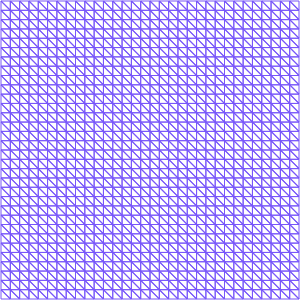

In [2]:
# First we define a mesh for the unit square
mesh= skfem.MeshTri().refined(5).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

print(mesh)
mesh


In [3]:
"""First step."""

# Assembling matrices

from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import grad, dot

# Bilinear form 
@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))

@BilinearForm
def gradu(u, v, w):    
    return - u*(v.grad[0]*w.bmu1+v.grad[1]*w.bmu2) 

@BilinearForm
def boundary_normal_gradient(u, v, w):
    """ Bilinear part for int(grad_n(u), v) on the left boundary """
    return dot(grad(u), w.n) * v

@BilinearForm
def mass(u, v, _): #H1 norm (norm for the space U)
    return u * v +dot(grad(u), grad(v))

@BilinearForm
def L2mass(u, v, _): #L2 norm
    return u * v 
    
  

In the code bellow, the function SolveAdvDiffProblem([mu1,mu2],Mesh,measures) takes as inputs the parameter $\mu \in \mathcal{P}^{bk} \subset \mathbb{R}^2$, a mesh, and a boolean used for the bias on the right-hand side function and on the dirichlet boundary conditions, and it returns the associated solution.

In [4]:
from skfem import *
# Compute solution 
element = ElementTriP1() #P1 FEM elements

def SolveAdvDiffProblem(mu,Mesh,measures):
    # mu: variable parameter
    # mesh: FE mesh
    # measures: Boolean (if true, the right-hand side function and dirichlet parameter are adapted to the generation of the data observations)
    basis = Basis(Mesh, element) 
    #print('Parameter mu:',mu)
    mu1,mu2=mu[0],mu[1]
    bmu1= lambda x: mu[0]*(np.cos(mu[1])) 
    bmu2= lambda x: mu[0]*(np.sin(mu[1])) 
    bmu1=basis.project(bmu1)
    bmu2=basis.project(bmu2)
    
    ## Assembling global problem
    A= laplace.assemble(basis)
    A2=gradu.assemble(basis,bmu1=basis.interpolate(bmu1),bmu2=basis.interpolate(bmu2))
    A+=A2

    ## boundary conditions
    left_basis = FacetBasis(Mesh, element, facets=Mesh.boundaries['right'])
    
    def profil_left(x):
        # Dirichlet boundary conditions
        if measures==True:
            #return (x[0]==1)*200*x[1]#(8*x[1]*(1-x[1])*(1+ np.sin(2*np.pi*x[1]))) #with g2!=0
            return (x[0]==1)*(4*x[1]*(1-x[1])*(1+ np.sin(2*np.pi*x[1]))) #with g2!=0
        else:
            #return (x[0]==1)*100*x[1]#(4*x[1]*(1-x[1]))  #with g2=0
            return (x[0]==1)*(4*x[1]*(1-x[1]))  #with g2=0

    u_boundary=left_basis.project(profil_left)
    D = basis.get_dofs(['right'])
    ## Neumann boundary conditions 
    A_boundary = boundary_normal_gradient.assemble(left_basis)
    A+=A_boundary

    ## Right hand side functions
    if measures==True:
        #g1 = lambda x: x[0]**2 -x[1] #with g1!=0
        g1 = lambda x: 0.2*x[0]**2 +x[0]*x[1] #with g1!=0
        g_proj1 = basis.project(g1)
    else:
        #g1 = lambda x: -x[1] #with g1=0
        g1 = lambda x: x[0]*x[1] #with g1!=0
        g_proj1 = basis.project(g1)
        
    f=g_proj1
    u = solve(*condense(A,f, x=u_boundary, D=D))

    return u
    


<Axes: >

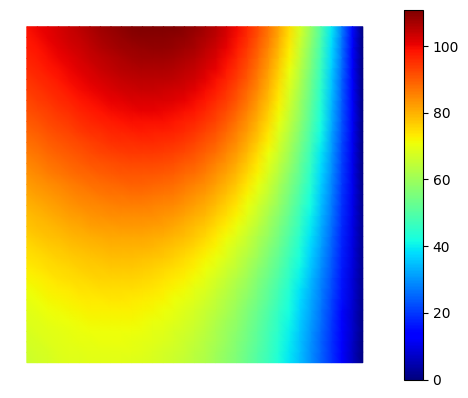

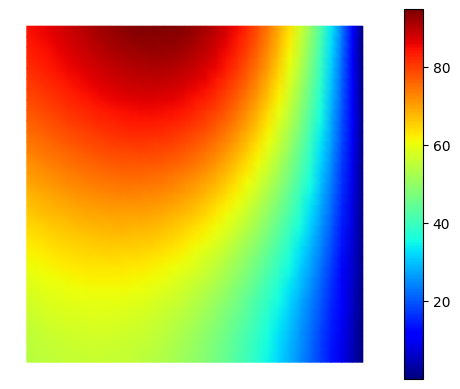

In [5]:
## plot the solution

from skfem.visuals.matplotlib import plot, draw, savefig

u=SolveAdvDiffProblem([0.4,np.pi/6],mesh,True) #
plot(mesh, u, shading='gouraud', colorbar=True)

u=SolveAdvDiffProblem([0.4,np.pi/6],mesh,False) # examples
plot(mesh, u, shading='gouraud', colorbar=True)


## The PBDW method

We are now able to proceed with the offline and online parts of the PBDW method.
We start with a classical POD algorithm on the bk model with bias, but first we construct the data observations $u^{true}(\mu^{true})$ artificially (here we consider that we have access to the data in the whole domain).

### OFFLINE PART


We define one fine mesh called "FineMesh" in the code

In [6]:
## FINE MESH
FineMesh = skfem.MeshTri().refined(5).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)
FineBasis = Basis(FineMesh, element)

NumberOfNodesFineMesh = FineMesh.p.shape[1]
print("number of nodes: ",NumberOfNodesFineMesh)
num_dofs_uFineMesh = FineBasis.doflocs.shape[1] # or np.shape(u)[0] for DOFs
print("number of DoFs: ",num_dofs_uFineMesh)

massMat=mass.assemble(FineBasis)
L2massMat=L2mass.assemble(FineBasis)

number of nodes:  1089
number of DoFs:  1089


<Axes: >

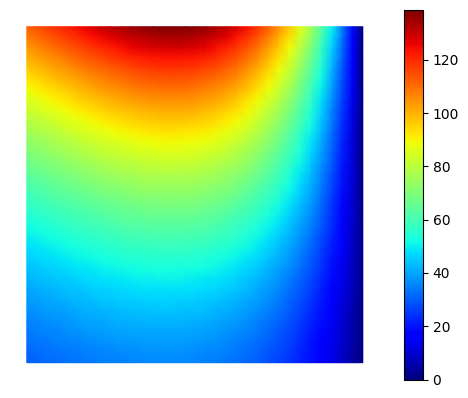

In [7]:
utrue=SolveAdvDiffProblem([1.4,np.pi/3],mesh,True) # True for measures
plot(FineMesh, utrue, shading='gouraud', colorbar=True)

#### POD on bk model

In [8]:
""" POD on the bk model (could be done with a greedy approach) """
print("-----------------------------------")
print("        Offline POD                ")
print("-----------------------------------")

NumberOfSnapshots=0
NumberOfModesN=15
print("number of modes for the bk model: ",NumberOfModesN)

mu1list=np.linspace(0.1,3,10)
mu2list=np.linspace(0,np.pi/2,10) 

FineSnapshots=[]

for mu1 in (mu1list):
    for mu2 in (mu2list):
        u=SolveAdvDiffProblem([mu1,mu2],FineMesh,False)
        FineSnapshots.append(u)
        NumberOfSnapshots+=1

## SVD ##
 
# We first compute the correlation matrix C_ij = (u_i,u_j)_U
CorrelationMatrix = np.zeros((NumberOfSnapshots, NumberOfSnapshots))
for i, snapshot1 in enumerate(FineSnapshots):
    MatVecProduct = massMat.dot(snapshot1)
    for j, snapshot2 in enumerate(FineSnapshots):
        if i >= j:
            CorrelationMatrix[i, j] = np.dot(MatVecProduct, snapshot2)
            CorrelationMatrix[j, i] = CorrelationMatrix[i, j]

# Then, we compute the eigenvalues/eigenvectors of C 
EigenValues, EigenVectors = np.linalg.eigh(CorrelationMatrix, UPLO="L") #SVD: C eigenVectors=eigenValues eigenVectors
idx = EigenValues.argsort()[::-1] # sort the eigenvalues

TotEigenValues = EigenValues[idx]
TotEigenVectors = EigenVectors[:, idx]
EigenValues=TotEigenValues[0:NumberOfModesN]

EigenVectors=TotEigenVectors[:,0:NumberOfModesN]
print("eigenvalues: ",EigenValues)

RIC=1-np.sum(EigenValues)/np.sum(TotEigenValues) #must be close to 0
print("Relativ Information Content:",RIC)

ChangeOfBasisMatrix = np.zeros((NumberOfModesN,NumberOfSnapshots))

for j in range(NumberOfModesN):#orthonormalization
    ChangeOfBasisMatrix[j,:] = EigenVectors[:,j]/np.sqrt(EigenValues[j])

bkReducedBasis = np.dot(ChangeOfBasisMatrix,FineSnapshots)


-----------------------------------
        Offline POD                
-----------------------------------
number of modes for the bk model:  15
eigenvalues:  [2.03866121e+06 1.98788941e+05 7.63460590e+04 3.57206711e+03
 3.26553742e+03 1.08125000e+03 4.08015648e+01 3.47784483e+01
 2.37761217e+01 4.40644071e+00 3.45055983e-01 1.56321411e-01
 1.29748847e-01 6.77589026e-02 9.30473722e-03]
Relativ Information Content: 1.3066825399477011e-09


Now we can check for the reduced basis accuracy.

In [9]:
print("-----------------------------------")
print("             Reduced basis accuracy")
print("-----------------------------------")
### Offline Errors
print("Offline Errors")
CompressionErrors=[]
H1compressionErrors=[]

#for snap in FineSnapshots:
#    ExactSolution =snap
for mu1 in (mu1list):
    for mu2 in (mu2list):
        ExactSolution=SolveAdvDiffProblem([mu1,mu2],FineMesh,False)
        #ExactSolutionbis=SolveAdvDiffProblem([mu1,mu2],FineMesh,False)
        CompressedSolutionU= ExactSolution@(massMat@bkReducedBasis.transpose())
        ReconstructedCompressedSolution = np.dot(CompressedSolutionU, bkReducedBasis) #pas de tps 0
    
        norml2ExactSolution=np.sqrt(ExactSolution@(L2massMat@ExactSolution))
        normh1ExactSolution=np.sqrt(ExactSolution@(massMat@ExactSolution))
        t=ReconstructedCompressedSolution-ExactSolution
    
        if norml2ExactSolution !=0 and normh1ExactSolution != 0:
            relError=np.sqrt(t@L2massMat@t)/norml2ExactSolution
            relh1Error=np.sqrt(t@massMat@t)/normh1ExactSolution
        else:
            relError = np.linalg.norm(ReconstructedCompressedSolution-ExactSolution)
        CompressionErrors.append(relError)
        H1compressionErrors.append(relh1Error)
        if mu1==2.275 and mu2==0:
            plot(FineMesh, ExactSolution, shading='gouraud', colorbar=True)
            plot(FineMesh, ExactSolutionbis, shading='gouraud', colorbar=True)
            plot(FineMesh, ReconstructedCompressedSolution, shading='gouraud', colorbar=True)
print("L2 compression error =", CompressionErrors)
print("H1 compression error =", H1compressionErrors)




-----------------------------------
             Reduced basis accuracy
-----------------------------------
Offline Errors
L2 compression error = [4.464044518872249e-06, 3.2948510494119077e-06, 2.290250760263449e-06, 1.4675605306478524e-06, 8.915840966017943e-07, 7.557337160345698e-07, 1.0344107189534399e-06, 1.4292838150362181e-06, 1.839008459568471e-06, 2.260403555595182e-06, 5.6419137062022195e-06, 3.0292521469093515e-06, 2.638316514323157e-06, 2.9735064128926414e-06, 3.1133058130523887e-06, 3.071241432378604e-06, 3.0903399820237977e-06, 3.4597258065352133e-06, 4.385570343265425e-06, 5.914766889195202e-06, 6.466039662035052e-06, 2.2828281714074417e-06, 3.719265675449631e-06, 4.07665068527531e-06, 3.733074907693582e-06, 3.3228223211801526e-06, 3.0466976159325082e-06, 2.8139328856957787e-06, 2.7628176702476534e-06, 4.417740843515894e-06, 6.878018194786359e-06, 4.343622954486847e-06, 5.6479455139503074e-06, 4.983955485533267e-06, 4.643064369149396e-06, 4.356187524270617e-06, 4.06890338

#### Construction of the sensors                                                                       
We now characterize our measures:

We will consider $M$ data  $y^{obs}(\mu^{true})\in \mathbb{C}^M$, obtained from sensors at different localizations such that:                                                                              
 $$\forall m=1,\dots,M, y_m^{obs}=l^0_m(u^{true}(\mu^{true})).$$                                                    
Here $y_m^{obs}(\mu^{true})$ is the value of the $m$-th observation, with $l_m^0 \in \mathcal{U}'$.                                          The form of the observation functional depends on the specific transducer used to acquire data. For instance, if the transducer measures a local state value, then we may model the observation as a Gaussian convolution (like in this example).

We first associate with each observation functional $l_m^0 \in \mathcal{U}'$ an observation function                                                                                                                                            
$$\forall m=1,\dots,M, \ q_m = R_u l^0_m,$$                                                                                                                                                                                            
which is the Riesz representation of the functional. 
The condition $(q_m,v)=l_m^0(v)$ is equivalent to the resolution of the following problem: 

Find $q_m \in \mathcal{U}$ such that:
$M q_m=b$ with $M $ the mass matrix and $b$ the vector obtained from the observation functionals $b_i=l_m^0(v_i)$ where $v_i$ are the FEM test functions. 

Then we introduce hierarchical observation spaces $\mathcal{U}_M \subset \mathcal{U}$ such that  
$$\forall M=1,\dots,M_{max},\ \mathcal{U}_M=\textrm{Span} \{ q_m\}_{m=1}^M. $$

We want to choose the localization of the sensors adequately in order to get $M$ small such that $(q_m)_{m=1}^M \in (\mathcal{U}_M)^M$ forms a canonical reduced basis of the observation spaces.

In our example, we consider Gaussian observation functionals with standard deviation $r_w = 0.01$:
$$l_m(v)=l_m(v,x_m,r_w)=C \int_{\Omega} exp \Big(-\frac{1}{2r_w^2}\lVert x-x_m \rVert_2^2 \Big) v(x) \ \textrm{dx},$$
where $C$ is such that $l_m(1)=1$, and $x_m$ corresponds to the center of the $m$-sensor localization.
In this example, we take these centers as the nodes of a coarser mesh but we could have used a GEIM to choose them more wisely.





In [10]:
rw = 0.01  # deviation r_w
xm = np.array([0.5, 0.5]) #for test

## Normalization of the gaussian functionals
## lm = C exp(-||x - x_m||^2 / (2 * r_w^2))
def gaussian_weight_noC(x,xm):
    """ Gaussian function centered on xm of deviation rw (to find C for normalization). """
    return np.exp(-0.5 * np.sum((x - xm[:, np.newaxis,np.newaxis])**2, axis=0) / rw**2)

def compute_C(xm):
    # takes xm center of sensor as parameter
    
    @LinearForm
    def lm(v, w):
        """ Computes lm(1) by integrating the Gaussian weight. """
 
        weight = gaussian_weight_noC(w.x,xm)
        return weight * v 

    # Assemble the linear form for lm(1)
    b = lm.assemble(FineBasis)
    lm_value = np.sum(b)  # Numerical integration result: b@1 since v=1
    
    C = 1.0 / lm_value  # Scaling factor
    return C

C = compute_C(xm)


In [11]:
# lm = C exp(-||x - x_m||^2 / (2 * r_w^2))
def gaussian_weight(x,xm,C):
    """ Gaussian function centered on xm of deviation rw """
    return C*np.exp(-0.5 * np.sum((x - xm[:, np.newaxis,np.newaxis])**2, axis=0) / rw**2)

def qm_b(xm,C):
    # weak formulation
    # mass matrix : (v, q_m)_U
    
    @LinearForm
    def rhs(v, w):
        """ Right hand side  """
        weight = gaussian_weight(w.x,xm,C)  # Applique la gaussienne
        return weight * v

    # Assembling
    b = rhs.assemble(FineBasis)

    # Solving the linear system
    from scipy.sparse.linalg import spsolve
    #from scipy.sparse.linalg import cg
    #q_m, info = cg(M, b)
    #if info == 0:
    #    print("Conjugate Gradient converged!")
    #else:
    #    print("Conjugate Gradient did not converge.")
    
    q_m = spsolve(massMat, b)  # Resolution of M @ q_m = b
    return q_m

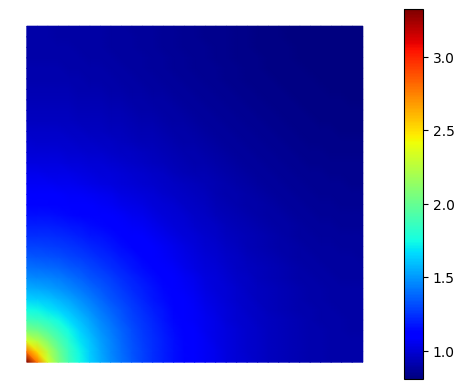

In [12]:
## sensors localizations from a coarser mesh M=25
## Coarse MESH
CoarseMesh = skfem.MeshTri().refined(3).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

xm_grid=CoarseMesh.p #xm = nodes

qmReducedBasis=np.zeros((num_dofs_uFineMesh,CoarseMesh.p.shape[1]))
for i in range(CoarseMesh.p.shape[1]):
    xm=xm_grid[:,i] #update xm
    C = compute_C(xm) # find C for normalization
    qmReducedBasis[:,i]=qm_b(xm,C) # generate qm
        
plot(FineMesh, qmReducedBasis[:,0], shading='gouraud', colorbar=True)
 
    
NumberOfModesM=np.shape(qmReducedBasis)[1]

Now we have two kind of basis functions:
- the $\Phi_i \in \mathcal{Z}_N$ for $i=1,\dots,N$ (in the code bkReducedBasis),
- the $q_j \in \mathcal{U}_M$, for $j=1,\dots,M$ (in the code qmReducedBasis).

#### PBDW algebraic form
We now state the algebraic form of the PBDW problem.
We need to compute  $(A)_{i,j}=(q_i,q_j)$ and $(B)_{i,j}=(\Phi_j,q_i)$ and to assemble $K= \begin{pmatrix} A & B \\
B^T & 0 \end{pmatrix}$ in order to solve $\begin{pmatrix} \eta_M \\ z_N \end{pmatrix} = K^{-1} \begin{pmatrix} y^{obs} \\ 0 \end{pmatrix}$

In [13]:
print("---------------------------------------")
print("---- OFFLINE PART: BUILDING MATRICES --")
print("---------------------------------------")

############################################
## Assembling A and B  #####################
############################################

AMat=massMat
BMat=massMat

#############################################
## Project matrices onto the reduced space ##
#############################################

Areduced = np.zeros((NumberOfModesM, NumberOfModesM))
Breduced = np.zeros((NumberOfModesM, NumberOfModesN))

for i in range(NumberOfModesM):
    MatAVecProduct = AMat.dot(qmReducedBasis[:,i])
    for j in range(NumberOfModesM):
        if j>=i:
            Areduced[i,j] = np.dot(qmReducedBasis[:,j],MatAVecProduct)
            Areduced[j,i] = Areduced[i,j]

for i in range(NumberOfModesM):
    MatBVecProduct = BMat.dot(qmReducedBasis[:,i])
    for j in range(NumberOfModesN):
        Breduced[i,j] = np.dot(bkReducedBasis[j],MatBVecProduct)
         
            

Kreduced = np.zeros((NumberOfModesN+NumberOfModesM,NumberOfModesN+ NumberOfModesM))
#fill global K
for i in range(NumberOfModesM):
    for j in range(NumberOfModesM):
        Kreduced[i,j]=Areduced[i,j]

for i in range(NumberOfModesM):
    for j in range(NumberOfModesN):
        Kreduced[i,NumberOfModesM+j]=Breduced[i,j]
        Kreduced[NumberOfModesM+j,i]=Breduced[i,j]



---------------------------------------
---- OFFLINE PART: BUILDING MATRICES --
---------------------------------------


#### ONLINE PART

We can now solve $\begin{pmatrix} \eta_M \\ z_N \end{pmatrix} = K^{-1} \begin{pmatrix} y^{obs} \\ 0 \end{pmatrix}$
and we approximate $u^{true}(\mu^{true})$ by $u=\sum_{i=1}^M (\eta_M)_i \ q_i +\sum_{i=1}^N (z_N)_i \ \Phi_i $.

--------------------------------------------
---- ONLINE PART: SOLVING REDUCED PROBLEM --
--------------------------------------------
L2 relative error:  0.0004129386415760589
H1 relative error:  0.003935527762515732


<Axes: >

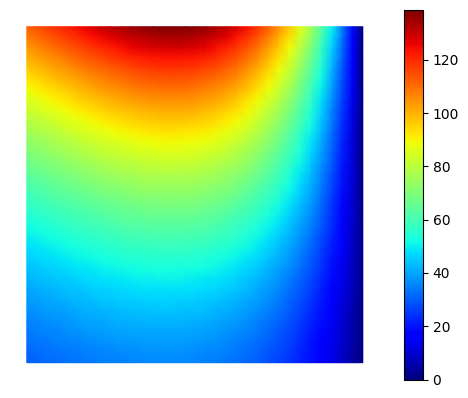

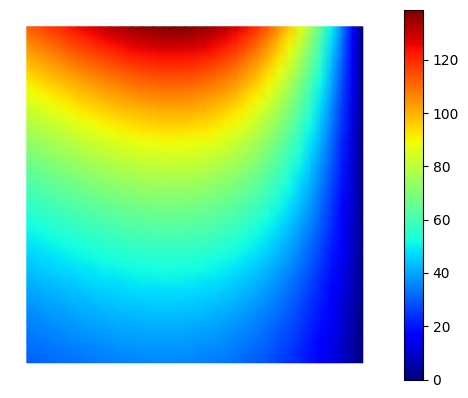

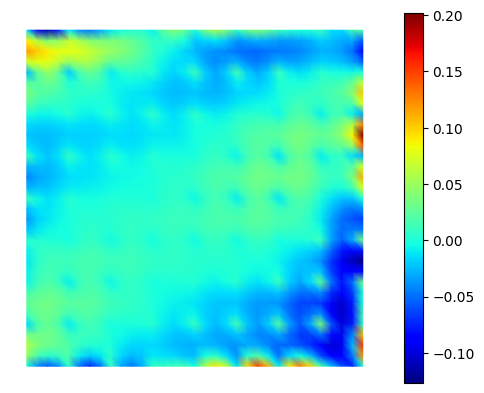

In [15]:
# Construct the observations from the basis (qm)_m and the true data
yobs = np.zeros(NumberOfModesM)

#mu1=mu1list[1]
#mu2=mu2list[2]
#utrue=SolveAdvDiffProblem([mu1,mu2],FineMesh,True)
# Compute (q_m, v)_U
qm_inner =utrue@ massMat

for i in range(NumberOfModesM):    
    yobs[i] =qm_inner.dot(qmReducedBasis[:,i])


print("--------------------------------------------")
print("---- ONLINE PART: SOLVING REDUCED PROBLEM --")
print("--------------------------------------------")

RightHandSide= np.concatenate([yobs, np.zeros(NumberOfModesN)]) 
## SOLVING PROBLEM ##
#EtaZ=np.linalg.solve(Kreduced,RightHandSide)
#Eta, Z = EtaZ[:NumberOfModesM],EtaZ[NumberOfModesM:]
#print("norm",np.linalg.norm(Areduced@Eta+Breduced@Z-yobs))
#print("norm",np.linalg.norm(Breduced.transpose()@Eta))
#u=np.dot(Eta,qmReducedBasis.transpose())+np.dot(Z,bkReducedBasis)

Z=np.linalg.solve(np.dot(np.dot(Breduced.transpose(),np.linalg.inv(Areduced)),Breduced),np.dot(np.dot(Breduced.transpose(),np.linalg.inv(Areduced)),yobs))
Eta=np.linalg.solve(Areduced,yobs-np.dot(Breduced,Z))
u=np.dot(Eta,qmReducedBasis.transpose())+np.dot(Z,bkReducedBasis)

ExactSolution =utrue #exact observations
ReconstructedCompressedSolution = u #reduced solution
    
norml2ExactSolution=np.sqrt(ExactSolution@(L2massMat@ExactSolution))
normh1ExactSolution=np.sqrt(ExactSolution@(massMat@ExactSolution))
t=np.abs(ReconstructedCompressedSolution-ExactSolution)

if norml2ExactSolution !=0 and normh1ExactSolution != 0:
    relError=np.sqrt(t@L2massMat@t)/norml2ExactSolution
    relh1Error=np.sqrt(t@massMat@t)/normh1ExactSolution
    
else:
    relError = np.linalg.norm(ReconstructedCompressedSolution-ExactSolution)
    
print("L2 relative error: ",relError)
print("H1 relative error: ",relh1Error)

plot(FineMesh,utrue, shading='gouraud', colorbar=True)
plot(FineMesh,u, shading='gouraud', colorbar=True)
#plot(FineMesh,np.dot(Z,bkReducedBasis)-utrue, shading='gouraud', colorbar=True)
plot(FineMesh,u-utrue, shading='gouraud', colorbar=True)